# Portfolio Optimization

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

##  Long-Only Two Asset Portfolio

[*********************100%***********************]  2 of 2 completed


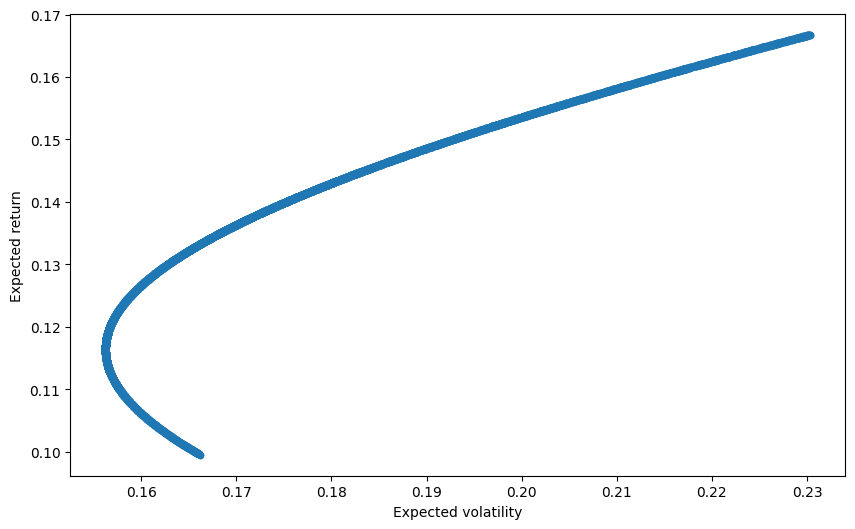

In [2]:
assets = ['HINDUNILVR.NS','^NSEI']
data = yf.download(assets, start = '2010-01-10', auto_adjust = False)
pfolio = data['Adj Close']
log_returns = np.log(pfolio/pfolio.shift(1))
num_assets = len(assets)

port_ret = []
port_vol = []

for x in range(10000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    port_ret.append(np.sum(weights * log_returns.mean()) * 250)
    port_vol.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 250, weights))))

port_ret = np.array(port_ret)
port_vol = np.array(port_vol)

portfolios = pd.DataFrame({'return': port_ret, 'volatility': port_vol})
portfolios.plot(x='volatility', y='return', kind='scatter', figsize=(10,6))
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.savefig('EF_2_stocks.png', dpi=300, bbox_inches='tight')
plt.show()

## Multi-Asset Efficient Frontier

[*********************100%***********************]  5 of 5 completed


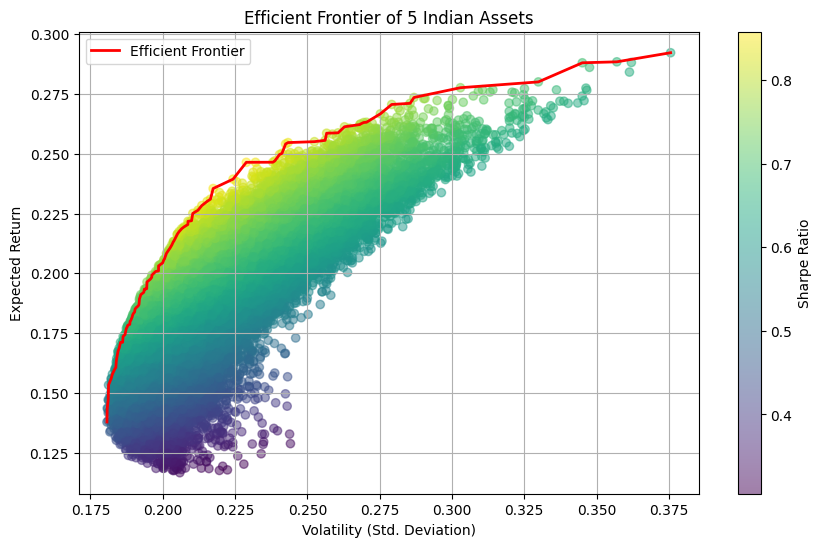

In [3]:
assets1 = ['HDFCBANK.NS', 'TATAMOTORS.NS', 'ASIANPAINT.NS', '^NSEI', '^NSEMDCP50']
data1 = yf.download(assets1, start="2020-01-10", auto_adjust=False)['Adj Close'].dropna()
returns = data1.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets1 = len(assets1)
num_portfolios = 100000


results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights1 = np.random.random(num_assets1)
    weights1 /= np.sum(weights1)
    port_return1 = np.dot(weights1, mean_returns) * 252
    port_volatility1 = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix * 252, weights1)))
    sharpe_ratio1 = (port_return1 - 0.05) / port_volatility1
    results[0, i] = port_volatility1
    results[1, i] = port_return1
    results[2, i] = sharpe_ratio1

# Scale reference
max_ret_long = np.max(results[1])
clip_lower = -1.5 * max_ret_long
clip_upper = 1.5 * max_ret_long

# Frontier (long only)
volatility = results[0]
returns_ = results[1]
efficient_idx = np.argsort(volatility)
sorted_vol = volatility[efficient_idx]
sorted_ret = returns_[efficient_idx]
frontier_vol, frontier_ret = [], []
last_v = -1
for v, r in zip(sorted_vol, sorted_ret):
    if round(v, 5) != last_v:
        if not frontier_ret or r > frontier_ret[-1]:
            frontier_vol.append(v)
            frontier_ret.append(r)
            last_v = round(v, 5)

plt.figure(figsize=(10,6))
scatter = plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.5)
plt.plot(frontier_vol, frontier_ret, color='red', linewidth=2, label='Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier of 5 Indian Assets')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.savefig('EF_5_stocks.png', dpi=300, bbox_inches='tight')
plt.show()

## Short Selling (Volatility ≤ 0.4)

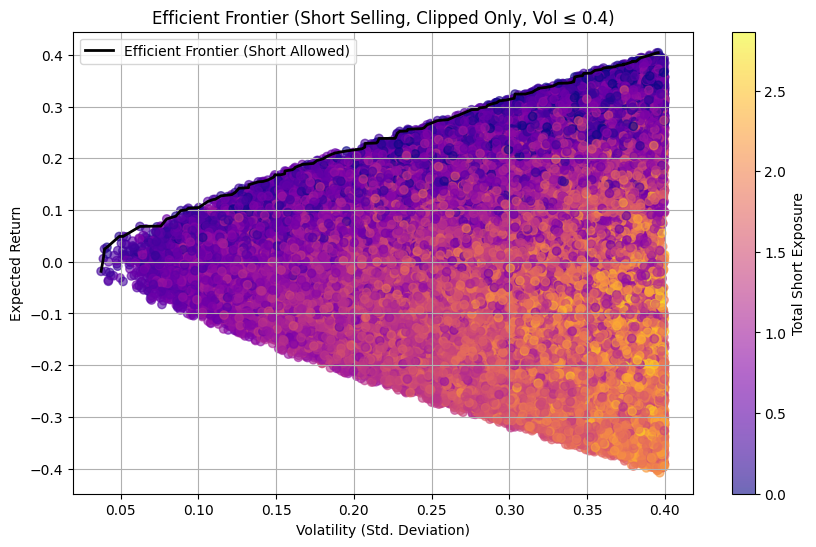

In [4]:
results_short = np.zeros((3, num_portfolios))
short_exposures = np.zeros(num_portfolios)
count_short = 0

for _ in range(num_portfolios * 2):  
    weights1 = np.random.uniform(-1, 1, num_assets1)
    port_volatility1 = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix * 252, weights1)))
    if port_volatility1 > 0.4:
        continue

    short_exposures[count_short] = np.sum(np.abs(weights1[weights1 < 0]))
    port_return1 = np.dot(weights1, mean_returns) * 252
    port_return1 = np.clip(port_return1, clip_lower, clip_upper)
    sharpe_ratio1 = (port_return1 - 0.05) / port_volatility1

    results_short[0, count_short] = port_volatility1
    results_short[1, count_short] = port_return1
    results_short[2, count_short] = sharpe_ratio1
    count_short += 1
    if count_short >= num_portfolios:
        break

# Frontier (short)
vol_short = results_short[0, :count_short]
ret_short = results_short[1, :count_short]
idx_sort = np.argsort(vol_short)
frontier_vol_short, frontier_ret_short = [], []
last_v = -1
for v, r in zip(vol_short[idx_sort], ret_short[idx_sort]):
    if round(v, 5) != last_v:
        if not frontier_ret_short or r > frontier_ret_short[-1]:
            frontier_vol_short.append(v)
            frontier_ret_short.append(r)
            last_v = round(v, 5)

plt.figure(figsize=(10,6))
scatter2 = plt.scatter(vol_short, ret_short, c=short_exposures[:count_short], cmap='plasma', alpha=0.6)
plt.plot(frontier_vol_short, frontier_ret_short, color='black', linewidth=2, label='Efficient Frontier (Short Allowed)')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Short Selling, Clipped Only, Vol ≤ 0.4)')
plt.colorbar(scatter2, label='Total Short Exposure')
plt.grid(True)
plt.legend()
plt.savefig('EF_short_clipped_vol_limited.png', dpi=300, bbox_inches='tight')
plt.show()

## Leverage (Volatility ≤ 0.4)

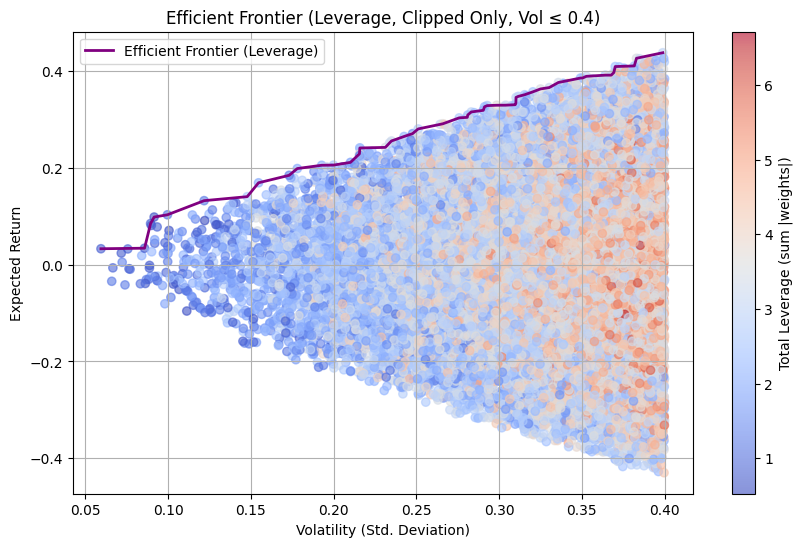

In [5]:
results_leverage = np.zeros((3, num_portfolios))
leverage_levels = np.zeros(num_portfolios)
count_lev = 0

for _ in range(num_portfolios * 2):  
    weights1 = np.random.uniform(-2, 2, num_assets1)
    port_volatility1 = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix * 252, weights1)))
    if port_volatility1 > 0.4:
        continue

    leverage_levels[count_lev] = np.sum(np.abs(weights1))
    port_return1 = np.dot(weights1, mean_returns) * 252
    port_return1 = np.clip(port_return1, clip_lower, clip_upper)
    sharpe_ratio1 = (port_return1 - 0.05) / port_volatility1

    results_leverage[0, count_lev] = port_volatility1
    results_leverage[1, count_lev] = port_return1
    results_leverage[2, count_lev] = sharpe_ratio1
    count_lev += 1
    if count_lev >= num_portfolios:
        break

vol_lev = results_leverage[0, :count_lev]
ret_lev = results_leverage[1, :count_lev]
idx_sort = np.argsort(vol_lev)
frontier_vol_lev, frontier_ret_lev = [], []
last_v = -1
for v, r in zip(vol_lev[idx_sort], ret_lev[idx_sort]):
    if round(v, 5) != last_v:
        if not frontier_ret_lev or r > frontier_ret_lev[-1]:
            frontier_vol_lev.append(v)
            frontier_ret_lev.append(r)
            last_v = round(v, 5)

plt.figure(figsize=(10,6))
scatter3 = plt.scatter(vol_lev, ret_lev, c=leverage_levels[:count_lev], cmap='coolwarm', alpha=0.6)
plt.plot(frontier_vol_lev, frontier_ret_lev, color='purple', linewidth=2, label='Efficient Frontier (Leverage)')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (Leverage, Clipped Only, Vol ≤ 0.4)')
plt.colorbar(scatter3, label='Total Leverage (sum |weights|)')
plt.grid(True)
plt.legend()
plt.savefig('EF_leverage_clipped_vol_limited.png', dpi=300, bbox_inches='tight')
plt.show()

## All Three Combined (Vol ≤ 0.4)

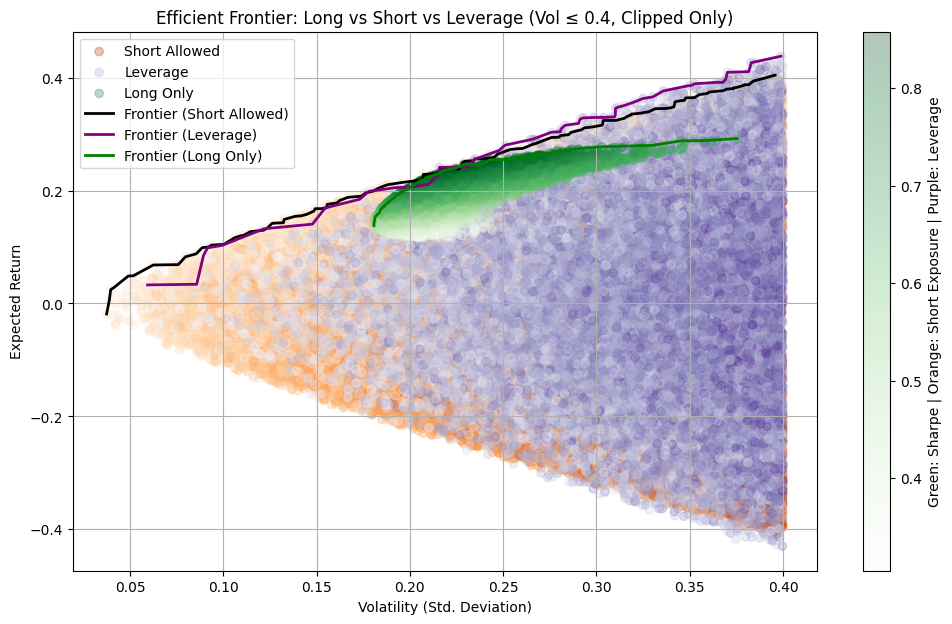

In [6]:
plt.figure(figsize=(12,7))
plt.scatter(vol_short, ret_short, c=short_exposures[:count_short], cmap='Oranges', alpha=0.3, label='Short Allowed')
plt.scatter(vol_lev, ret_lev, c=leverage_levels[:count_lev], cmap='Purples', alpha=0.3, label='Leverage')
plt.scatter(results[0], results[1], c=results[2], cmap='Greens', alpha=0.3, label='Long Only')
plt.plot(frontier_vol_short, frontier_ret_short, color='black', linewidth=2, label='Frontier (Short Allowed)')
plt.plot(frontier_vol_lev, frontier_ret_lev, color='purple', linewidth=2, label='Frontier (Leverage)')
plt.plot(frontier_vol, frontier_ret, color='green', linewidth=2, label='Frontier (Long Only)')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier: Long vs Short vs Leverage (Vol ≤ 0.4, Clipped Only)')
plt.grid(True)
plt.legend()
cbar = plt.colorbar(label='Green: Sharpe | Orange: Short Exposure | Purple: Leverage')
plt.savefig('EF_complete_clipped_vol_limited.png', dpi=300, bbox_inches='tight')
plt.show()